In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %%
import os
import pickle
from functools import partial

from dgp import get_dataloader
from utils.llc import calculate_llc_for_file
from utils.loading import Conf, load_model_from_hf
from utils import move_to_device

import torch.nn.functional as F


In [3]:
# %%

device = "cpu"

hf_repo_name = "cybershiptrooper/ConceptPerlocation_ckpts_98k"
dump_dir = f"results/scratch/{hf_repo_name}/llc"
model_dir = f"results/scratch/{hf_repo_name}"


os.makedirs(dump_dir, exist_ok=True)


In [4]:
# %%

model = load_model_from_hf(0, hf_repo_name, epoch=0)
config = Conf(**model["config"])

config.device = device

dataloader = get_dataloader(
    n_relative_properties=config.data.n_relative_properties,
    n_descriptive_properties=config.data.n_descriptive_properties,
    n_descriptive_values=config.data.n_descriptive_values,
    num_of_classes_to_divide_over=config.data.num_of_classes_to_divide_over,
    prior_param=config.data.prior_param,
    props_prior_type=config.data.props_prior_type,
    n_entities=config.data.n_entities,
    instr_ratio=config.data.instr_ratio,
    max_sample_length=config.data.max_sample_length,
    num_iters=5e5 * config.data.batch_size,
    batch_size=config.data.batch_size,
    num_workers=config.data.num_workers,
    seed=config.seed,
    evaluation=True
)


/Users/cybershiptrooper/src/interpretability/devinterp/timaeus/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cybershiptrooper/src/interpretability/devinterp/timaeus/projects/power-laws/src/ConceptPercolation/utils/loading.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode 

In [5]:
# %%
pad_token_id = dataloader.dataset.pad_token_id


def evaluate_fn(model, data, pad_token_id, config):
    sequences, symb_sequences, seq_lengths, seq_logprobs, _ = data
    B = sequences.size(0)
    inputs, labels = move_to_device([sequences[:, :-1], sequences[:, 1:]], config.device)
    labels = labels.clone()
    labels[labels == pad_token_id] = -100  # Mask padding
    logits = model(inputs)  # (B, L-1, V)
    loss = F.cross_entropy(
        logits.reshape(-1, logits.size(-1)),
        labels.reshape(-1),
        ignore_index=-100,
        reduction="none",
    )  # (B*L-1)
    loss = loss.reshape(B, -1).mean()
    return loss, {}


evaluator = partial(evaluate_fn, pad_token_id=pad_token_id, config=config)

from utils.llc import evaluate_fn

evaluator = evaluate_fn


In [6]:
# %%
from tqdm import tqdm

llc_outputs = []
iters = (
    list(range(0, 200, 10))
    + list(range(200, 1200, 20))
    + list(range(1200, 5_001, 50))
    + list(range(5_100, 10_001, 100))
    + list(range(10_500, 25_501, 500))
    + list(range(86_000, 100_501, 1000))
)
iters = [2000, 20_000]
for iter in tqdm(iters):
    print(f"Calculating LLC for iteration {iter}")
    llc_output = calculate_llc_for_file(
        iter,
        dataloader,
        model_dir=hf_repo_name,
        config=config,
        evaluate_fn=evaluator,
        model_loader=load_model_from_hf,
        num_chains=5,
        num_draws=200,
    )
    llc_outputs.append(llc_output)
    with open(f"{dump_dir}/llc_output_it_{iter}.pkl", "wb") as f:
        pickle.dump(llc_output, f)


  0%|          | 0/2 [00:00<?, ?it/s]

Calculating LLC for iteration 2000


/Users/cybershiptrooper/src/interpretability/devinterp/timaeus/shared/devinterp/src/devinterp/backends/default/slt/sampler.py:215: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/cybershiptrooper/src/interpretability/devinterp/timaeus/shared/devinterp/src/devinterp/backends/default/slt/sampler.py:251: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
 50%|█████     | 1/2 [01:31<01:31, 91.47s/it]

Calculating LLC for iteration 20000


/Users/cybershiptrooper/src/interpretability/devinterp/timaeus/projects/power-laws/src/ConceptPercolation/utils/loading.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

In [7]:
llc_outputs

[{'llc/mean': 25.649852752685547,
  'llc/std': 0.5852469205856323,
  'llc-chain/0': 25.88930320739746,
  'llc-chain/1': 25.64059829711914,
  'llc-chain/2': 26.319507598876953,
  'llc-chain/3': 25.679168701171875,
  'llc-chain/4': 24.720693588256836,
  'loss/trace': array([[0.74244505, 1.1279935 , 1.3129472 , 1.5267929 , 1.6510447 ,
          1.7018248 , 1.7016087 , 1.6542187 , 1.6478628 , 1.906564  ,
          1.84007   , 1.6597782 , 1.7569752 , 1.6206813 , 1.4935561 ,
          1.4794382 , 1.5764313 , 1.5534523 , 1.5342704 , 1.5942653 ,
          1.5584263 , 1.6376038 , 1.5181745 , 1.768265  , 1.6361774 ,
          1.6126014 , 1.5775483 , 1.6792297 , 1.7742227 , 1.7309842 ,
          1.7740194 , 1.620374  , 1.6443592 , 1.7198981 , 1.7916462 ,
          1.607331  , 1.8245571 , 1.5721346 , 1.5978012 , 1.6995143 ,
          1.7067715 , 1.7618985 , 1.5418422 , 1.8257191 , 1.6567266 ,
          1.6033661 , 1.6941068 , 1.7003307 , 2.0001705 , 1.8365713 ,
          1.770538  , 1.7579162 , 1.

In [ ]:
import matplotlib.pyplot as plt

for i in range(llc_outputs[0]["loss/trace"].shape[0]):
    plt.plot(llc_outputs[0]["loss/trace"][i], color="darkcyan")
    plt.plot(llc_outputs[1]["loss/trace"][i], color="orangered")



In [ ]:
[llc_outputs[i]["llc/mean"] for i in range(len(llc_outputs))]

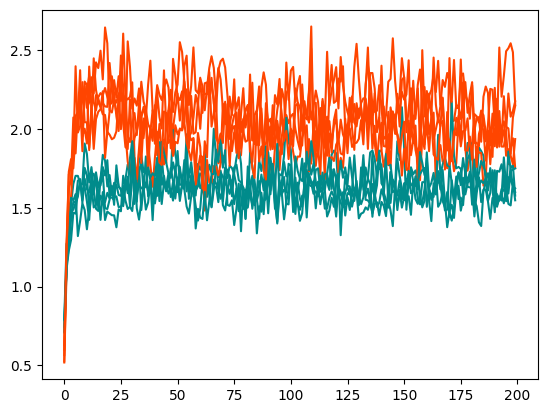

In [8]:
import matplotlib.pyplot as plt

for i in range(llc_outputs[0]["loss/trace"].shape[0]):
    plt.plot(llc_outputs[0]["loss/trace"][i], color="darkcyan")
    plt.plot(llc_outputs[1]["loss/trace"][i], color="orangered")



In [9]:
[llc_outputs[i]["llc/mean"] for i in range(len(llc_outputs))]

[25.649852752685547, 43.755157470703125]

In [10]:
llc_outputs[0].keys()

dict_keys(['llc/mean', 'llc/std', 'llc-chain/0', 'llc-chain/1', 'llc-chain/2', 'llc-chain/3', 'llc-chain/4', 'loss/trace'])